In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/houkongtest/stock_train_data.csv
/kaggle/input/houkongtest/stock_test_data.csv


In [9]:
# Standard Python Imports
import os
import json
import re
import string
import random
import time
import datetime
import matplotlib.pyplot as plt

# Extra non-standard utilities
from argparse import Namespace
from collections import Counter
from tqdm import tqdm

# Data management and Math imports
import numpy as np
import pandas as pd

# Torch Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset 
import copy

from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression

In [3]:
df = pd.read_csv("/kaggle/input/houkongtest/stock_train_data.csv")
df

,id,date,open,high,low,close,volume,adj_close
0,1,2020-01-01,104.137445,105.336570,101.888063,103.452150,94093,102.546070
1,2,2020-01-02,102.030543,102.243290,100.160189,101.423024,101968,101.260087
2,3,2020-01-03,97.250072,97.450643,96.624196,98.168974,103752,97.330620
3,4,2020-01-04,92.592000,94.713176,89.907974,92.024300,104207,92.640590
4,5,2020-01-05,89.850982,90.289664,88.027048,91.130187,94854,91.772165
...,...,...,...,...,...,...,...,...
1495,1496,2024-02-04,-21.151421,-20.764677,-23.282672,-21.673139,53469,-21.670244
1496,1497,2024-02-05,-18.697602,-18.685963,-20.843889,-18.447026,51435,-18.495587
1497,1498,2024-02-06,-14.312172,-13.467672,-17.200586,-12.386975,58108,-12.287926
1498,1499,2024-02-07,-9.496567,-7.847834,-9.859621,-11.494308,48258,-11.392723


In [4]:
df = df.drop(columns = ['id', 'date', 'adj_close'])
df

,open,high,low,close,volume
0,104.137445,105.336570,101.888063,103.452150,94093
1,102.030543,102.243290,100.160189,101.423024,101968
2,97.250072,97.450643,96.624196,98.168974,103752
3,92.592000,94.713176,89.907974,92.024300,104207
4,89.850982,90.289664,88.027048,91.130187,94854
...,...,...,...,...,...
1495,-21.151421,-20.764677,-23.282672,-21.673139,53469
1496,-18.697602,-18.685963,-20.843889,-18.447026,51435
1497,-14.312172,-13.467672,-17.200586,-12.386975,58108
1498,-9.496567,-7.847834,-9.859621,-11.494308,48258


In [5]:
X = df.drop(columns = ['close'])
y = df['close'].values
X

,open,high,low,volume
0,104.137445,105.336570,101.888063,94093
1,102.030543,102.243290,100.160189,101968
2,97.250072,97.450643,96.624196,103752
3,92.592000,94.713176,89.907974,104207
4,89.850982,90.289664,88.027048,94854
...,...,...,...,...
1495,-21.151421,-20.764677,-23.282672,53469
1496,-18.697602,-18.685963,-20.843889,51435
1497,-14.312172,-13.467672,-17.200586,58108
1498,-9.496567,-7.847834,-9.859621,48258


In [6]:
y

array([103.45215   , 101.42302391,  98.16897432, ..., -12.38697522,
       -11.49430787,  -9.966321  ])

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X.values, y, test_size=0.2, random_state=42
)

In [11]:
X_train

array([[ 3.26482315e+01,  3.35090739e+01,  3.09292649e+01,
         1.65490000e+04],
       [ 3.45143587e+01,  3.67085087e+01,  3.26841712e+01,
         1.00000000e+04],
       [-1.76818405e+01, -1.56790630e+01, -1.92493905e+01,
         6.12060000e+04],
       ...,
       [ 1.76303863e+01,  2.01113794e+01,  1.59572804e+01,
         2.03970000e+04],
       [-2.22359424e+01, -2.18770167e+01, -2.37390875e+01,
         2.33820000e+04],
       [-1.54965669e+01, -1.52917114e+01, -1.78377267e+01,
         1.86690000e+05]])

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X_train_t = torch.from_numpy(X_train).float().to(device)
y_train_t = torch.from_numpy(y_train).float().to(device)
X_test_t  = torch.from_numpy(X_test).float().to(device)
y_test_t  = torch.from_numpy(y_test).float().to(device)

train_ds = TensorDataset(X_train_t, y_train_t)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_ds = TensorDataset(X_test_t, y_test_t)
val_loader = DataLoader(val_ds, batch_size=64)

In [13]:
from argparse import Namespace
from collections import Counter
from tqdm import tqdm

args = Namespace(
    data_path = "./apartments_small.csv",
    train_split = 0.8,
    test_split = 0.2,
    val_split=0.25,
    seed=5059,
    batch_size=16,
    lr=0.001,
    epochs=100
)

In [14]:
class RegressionModel(nn.Module):
    ''' 
        Basic NN implementation
    '''

    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1) # ensure single value output
        )

    def forward(self, x):
        return self.net(x)

In [15]:
def train_model(model, train_loader, val_loader):
    loss_fn = nn.MSELoss()  # mean square error loss function
    optimizer = optim.Adam(model.parameters(), lr=args.lr) # adam optimizer

    train_loss_history = []
    val_loss_history = []

    best_loss = np.inf # initialize as infinity
    best_weights = None

    for epoch in tqdm(range(args.epochs), desc="Epochs", unit="epoch"):
        ''' 
            Train
        '''
        model.train() # Set model to training mode 
        train_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad() # reset gradients for optimizer

            predictions = model(X_batch) # forward

            loss = loss_fn(predictions, y_batch) 
            loss.backward() # backward pass - compute loss gradients 

            optimizer.step() # update model parameters wrt loss gradients 

            train_loss += loss.item()        

        train_loss_history.append(train_loss)

        ''' 
            Validation
        '''
        model.eval() # set model to evaluation mode
        val_loss = 0
        with torch.no_grad(): # disable gradient computation (for efficiency)
            for X_batch, y_batch in val_loader:
                predictions = model(X_batch)
                loss = loss_fn(predictions, y_batch)

                val_loss += loss.item()

        val_loss_history.append(val_loss)

        ''' 
            Check if improvements made this epoch
        '''
        if val_loss < best_loss:
            best_loss = val_loss
            best_weights = copy.deepcopy(model.state_dict())

    
    return {
        "train_loss_history" : train_loss_history,
        "val_loss_history": val_loss_history,
        "best_weights":best_weights,
        "best_loss" : best_loss
    }

In [16]:
def plot_loss(loss_history, title):
    ''' 
        Plots loss trajectory across training epochs
    '''

    plt.figure(figsize=(8,4))
    plt.plot([i for i in range(len(loss_history))], loss_history)
    plt.title(title)
    plt.xlabel("epoch")
    plt.ylabel("Mean Square Error")
    plt.show()

In [17]:
def plot_predictions_vs_labels(X_test, y_test, y_pred):
    plt.figure(figsize=(10,6))
    plt.plot([i for i in range(len(X_test))], y_test, color="red", label="label")
    plt.plot([i for i in range(len(X_test))], y_pred, color="blue", label="predictions")
    plt.xlabel("Datapoints")
    plt.ylabel("Price")
    plt.legend()
    plt.show()

In [18]:
X_test.shape[1]

4

In [19]:
nn_model = RegressionModel(input_dim=4)

In [20]:
train_results = train_model(nn_model, train_loader, val_loader)

Epochs:   0%|          | 0/100 [00:00<?, ?epoch/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([48])) that is different to the input size (torch.Size([48, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([44])) that is different to the input size (torch.Size([44, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure t

In [21]:
train_loss_history = train_results['train_loss_history']
val_loss_history = train_results['val_loss_history']
best_weights = train_results['best_weights']
best_loss = train_results['best_loss']

Best MSE Loss :  107.91326755978473


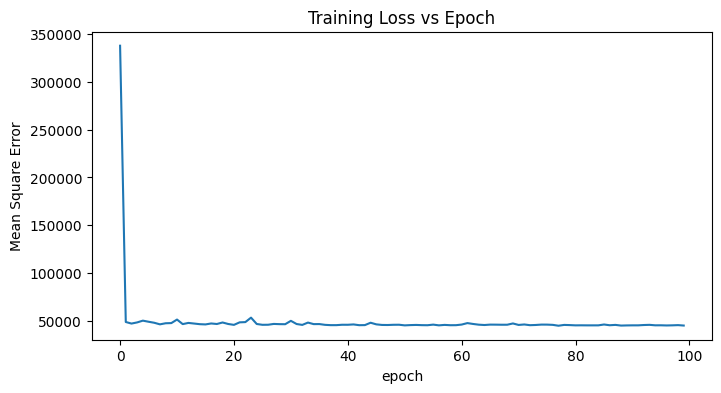

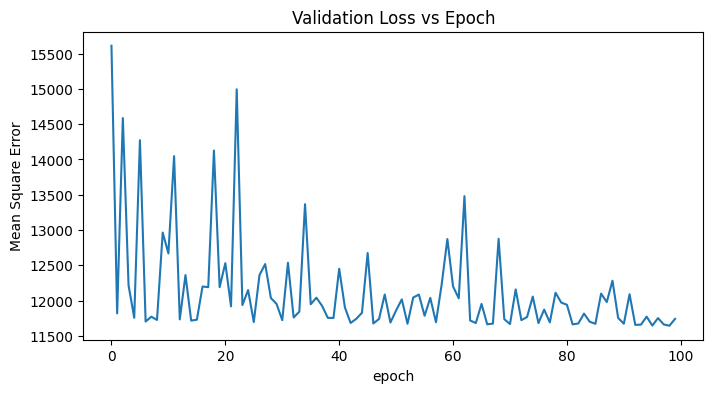

In [22]:
print("Best MSE Loss : ", np.sqrt(best_loss))

plot_loss(train_loss_history, "Training Loss vs Epoch")
plot_loss(val_loss_history, "Validation Loss vs Epoch")

In [40]:
test = pd.read_csv("/kaggle/input/houkongtest/stock_test_data.csv")

test

,date,open,high,low,volume,adj_close
0,2024-02-09,64.217540,67.120519,62.056126,109241,63.473761
1,2024-02-10,63.996529,66.075604,63.633681,105939,65.039274
2,2024-02-11,62.983233,64.875152,61.678532,105692,65.083193
3,2024-02-12,63.023560,64.535805,61.275462,99532,64.323752
4,2024-02-13,64.880834,66.720266,64.708353,103976,66.364234
...,...,...,...,...,...,...
495,2025-06-18,29.048598,30.268272,28.232786,144479,28.705003
496,2025-06-19,30.670911,32.326131,27.826621,143250,28.947784
497,2025-06-20,29.426022,31.409296,27.348696,135449,28.192249
498,2025-06-21,26.292295,27.369338,26.042563,139356,24.342610


In [42]:
test = test.drop(columns = ['date', 'adj_close'])
test

,open,high,low,volume
0,64.217540,67.120519,62.056126,109241
1,63.996529,66.075604,63.633681,105939
2,62.983233,64.875152,61.678532,105692
3,63.023560,64.535805,61.275462,99532
4,64.880834,66.720266,64.708353,103976
...,...,...,...,...
495,29.048598,30.268272,28.232786,144479
496,30.670911,32.326131,27.826621,143250
497,29.426022,31.409296,27.348696,135449
498,26.292295,27.369338,26.042563,139356


In [43]:
nn_model.load_state_dict(best_weights)
nn_model.eval()

RegressionModel(
  (net): Sequential(
    (0): Linear(in_features=4, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): ReLU()
    (8): Linear(in_features=32, out_features=16, bias=True)
    (9): ReLU()
    (10): Linear(in_features=16, out_features=1, bias=True)
  )
)

In [44]:
test = test.values
pred = nn_model(torch.tensor(test, dtype=torch.float32))

In [51]:
len(pred)

500

In [46]:
pred = pred.detach().numpy()

In [47]:
lst = []
for i in pred:
    lst.append(i[0])

In [52]:
test = pd.read_csv("/kaggle/input/houkongtest/stock_test_data.csv")

test = test['date']

In [61]:
submission = pd.DataFrame({
    "id": range(1501, 2001),  # 自动生成 ID
    "close": lst
})
submission.to_csv("submission.csv", index=False)

In [62]:
submission

,id,close
0,1501,14.392490
1,1502,13.981938
2,1503,13.950141
3,1504,13.183282
4,1505,13.738294
...,...,...
495,1996,18.753975
496,1997,18.601460
497,1998,17.629959
498,1999,18.114609
